In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import scanpy as sc
import scvi

sc.set_figure_params(figsize=(4, 4))

In [2]:
adata = scvi.data.pbmcs_10x_cite_seq(run_setup_anndata=False)
adata

INFO     File data/pbmc_10k_protein_v3.h5ad already downloaded                               
INFO     File data/pbmc_5k_protein_v3.h5ad already downloaded                                


/home/icb/anastasia.litinetskaya/miniconda3/envs/scvi-env/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


AnnData object with n_obs × n_vars = 10849 × 15792
    obs: 'n_genes', 'percent_mito', 'n_counts', 'batch', 'labels'
    var: 'encode', 'n_cells-0', 'highly_variable-0', 'hvg_encode-0', 'n_cells-1', 'highly_variable-1', 'hvg_encode-1'
    obsm: 'protein_expression'

In [3]:
# batch 0 corresponds to dataset_10k, batch 1 corresponds to dataset_5k
batch = adata.obs.batch.values.ravel()
adata.obs.batch

index
AAACCCAAGATTGTGA-1-0    0
AAACCCACATCGGTTA-1-0    0
AAACCCAGTACCGCGT-1-0    0
AAACCCAGTATCGAAA-1-0    0
AAACCCAGTCGTCATA-1-0    0
                       ..
TTTGGTTGTACGAGTG-1-1    1
TTTGTTGAGTTAACAG-1-1    1
TTTGTTGCAGCACAAG-1-1    1
TTTGTTGCAGTCTTCC-1-1    1
TTTGTTGCATTGCCGG-1-1    1
Name: batch, Length: 10849, dtype: int64

In [4]:
held_out_proteins = adata.obsm["protein_expression"][batch == 1].copy()
adata.obsm["protein_expression"].loc[batch == 1] = np.zeros_like(adata.obsm["protein_expression"][batch == 1])

In [5]:
adata.obs.batch = adata.obs.batch.astype('category')
sc.pp.highly_variable_genes(adata, 
                            flavor='seurat_v3', 
                            subset=True,
                            n_top_genes=4000)

/home/icb/anastasia.litinetskaya/miniconda3/envs/scvi-env/lib/python3.7/site-packages/scanpy/preprocessing/_highly_variable_genes.py:144: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[: int(n_top_genes), 'highly_variable'] = True


In [6]:
adata.write('10x-cite.h5ad')

In [7]:
scvi.data.setup_anndata(adata, batch_key="batch", protein_expression_obsm_key="protein_expression")

INFO     Using batches from adata.obs["batch"]                                               
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Using protein expression from adata.obsm['protein_expression']                      


/home/icb/anastasia.litinetskaya/miniconda3/envs/scvi-env/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/icb/anastasia.litinetskaya/miniconda3/envs/scvi-env/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


INFO     Using protein names from columns of adata.obsm['protein_expression']                
INFO     Found batches with missing protein expression                                       
INFO     Successfully registered anndata object containing 10849 cells, 4000 genes, 2        
         batches, 1 labels, and 14 proteins. Also registered 0 extra categorical covariates  
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


In [8]:
model = scvi.model.TOTALVI(
    adata, 
    latent_distribution="normal", 
    n_layers_decoder=2
)

In [9]:
model.train()

INFO     KL warmup for 8136.75 iterations                                                    


Output()

INFO     Reducing LR on epoch 313.                                                           
INFO     Training time:  739 s. / 400 epochs                                                 


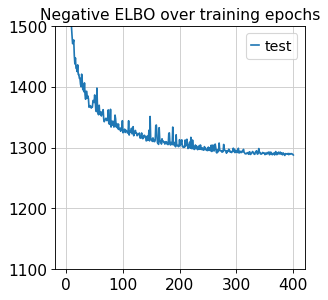

In [11]:
plt.plot(model.trainer.history["elbo_test_set"], label="test")
plt.title("Negative ELBO over training epochs")
plt.ylim(1100, 1500)
plt.legend()

In [13]:
_, protein_means = model.get_normalized_expression(
    n_samples=25,
    transform_batch=0,
    include_protein_background=True,
    sample_protein_mixing=False,
    return_mean=True,
)

In [18]:
adata.obsm["X_totalVI"] = model.get_latent_representation()

In [19]:
sc.pp.neighbors(adata, use_rep="X_totalVI")
sc.tl.umap(adata, min_dist=0.4)

In [14]:
batch = adata.obs.batch.values.ravel()
combined_protein = np.concatenate([adata.obsm["protein_expression"].values[batch==0], held_out_proteins], axis=0)

# cleaner protein names
parsed_protein_names = [p.split("_")[0] for p in adata.obsm["protein_expression"].columns]
for i, p in enumerate(parsed_protein_names):
    adata.obs["{} imputed".format(p)] = protein_means.iloc[:, i]
    adata.obs["{} observed".format(p)] = combined_protein[:, i]

/home/icb/anastasia.litinetskaya/miniconda3/envs/scvi-env/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


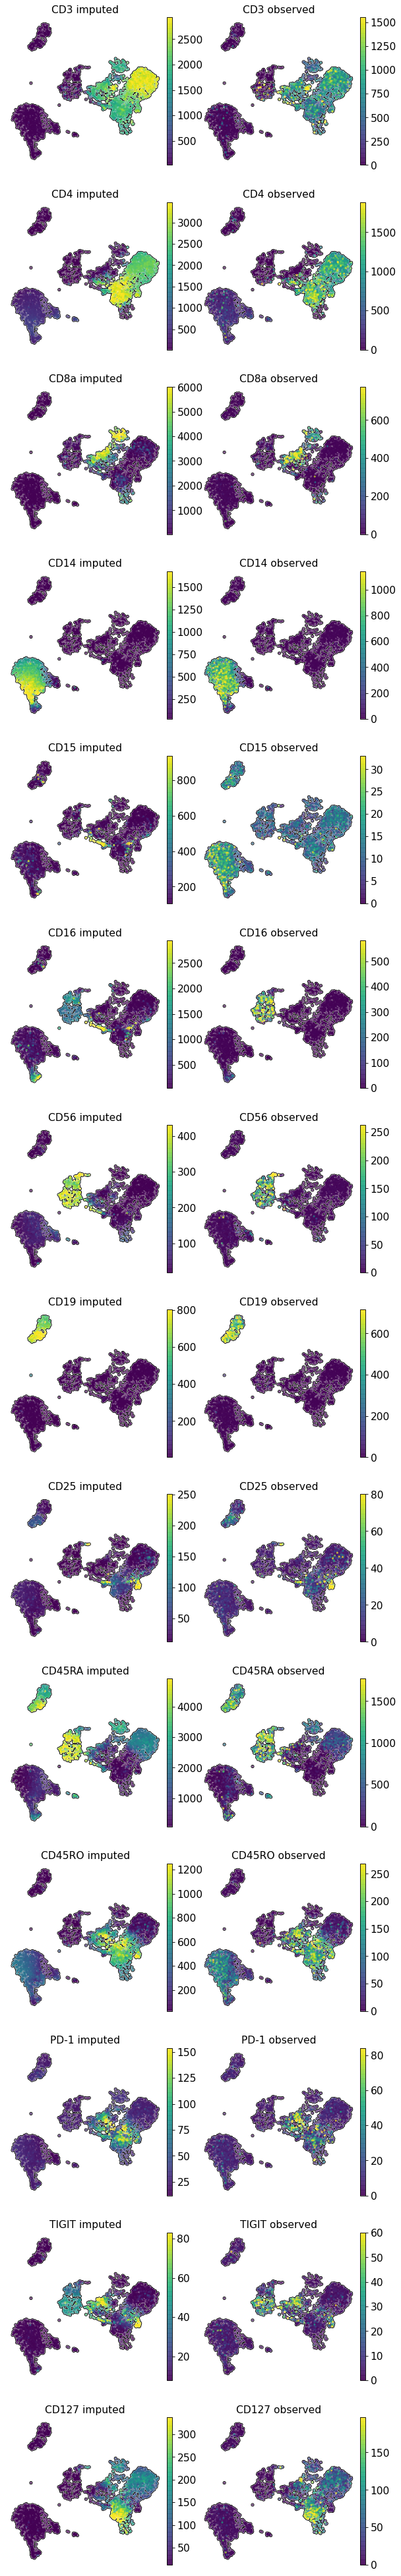

In [20]:
viz_keys = []
for p in parsed_protein_names:
    viz_keys.append(p + " imputed")
    viz_keys.append(p + " observed")

sc.pl.umap(
    adata[adata.obs.batch == 1],
    color=viz_keys,
    ncols=2,
    vmax="p99",
    frameon=False,
    add_outline=True,
    wspace=0.1
)

In [25]:
from scipy.stats import pearsonr
imputed_pros = protein_means[batch == 1]
held_vs_denoised = pd.DataFrame()
held_vs_denoised["Observed (log)"] = np.log1p(held_out_proteins.values.ravel())
held_vs_denoised["Imputed (log)"] = np.log1p(imputed_pros.to_numpy().ravel())
protein_corrs = []
for i, p in enumerate(parsed_protein_names):
    protein_corrs.append(parsed_protein_names[i] + ": Corr=" + str(np.round(pearsonr(held_out_proteins.values[:, i], imputed_pros.iloc[:, i])[0], 3)))

held_vs_denoised["Protein"] = protein_corrs * len(held_out_proteins)
held_vs_denoised.head()

,Observed (log),Imputed (log),Protein
0,3.258097,3.463355,CD3: Corr=0.783
1,5.105945,6.004158,CD4: Corr=0.868
2,2.833213,3.441109,CD8a: Corr=0.807
3,6.546785,7.210710,CD14: Corr=0.91
4,2.995732,4.715518,CD15: Corr=0.015


In [27]:
protein_corrs

['CD3: Corr=0.783',
 'CD4: Corr=0.868',
 'CD8a: Corr=0.807',
 'CD14: Corr=0.91',
 'CD15: Corr=0.015',
 'CD16: Corr=0.382',
 'CD56: Corr=0.813',
 'CD19: Corr=0.894',
 'CD25: Corr=0.739',
 'CD45RA: Corr=0.791',
 'CD45RO: Corr=0.74',
 'PD-1: Corr=0.592',
 'TIGIT: Corr=0.651',
 'CD127: Corr=0.79']